# Purpose

Fine-tune a multi label img classifier on COCO.

In [ ]:
from fastai.vision.all import *

# DataFrame

We first run some terminal commands to explore the file structure that our data came in. We're exploring it to identify how the images and labels are stored. Our goal is to create a list of ims and a list of labels to turn into a df.

In [ ]:
!ls /home/rory/data/coco2017

_20201002_coco_lbbloss.pkl.pth		   data.pkl
20201020_coco_multiple_bboxes_df.pkl	   image_info_test2017.zip
20201020_coco_multiple_bboxes_pets_df.pkl  models
20201027_coco_animals_df.pkl		   singles.pkl
20201027_coco_df.pkl			   test2017
20201029_coco_ss_df.pkl			   test2017.zip
annotations				   train2017
annotations_trainval2017.zip		   train2017.zip
coco_df.pkl				   val2017
data.csv				   val2017.zip
data.pickle


After poking around, here's what I discovered about the file organization:
- ~/data/coco2017/
    - annotations/
        - instances_train2017.json
        - instances_val2017.json
    - test2017/
        - contains many .jpg's w/12-digit img id for file name
    - train2017/
    - val2017/
    - data.csv

In [ ]:
folder = Path('/home/rory/data/coco2017')

 Let's use the wonderful fast.ai helper function for parsing COCO-style json annotations!

In [ ]:
ims, annos = get_annotations(folder/'annotations'/'instances_train2017.json')

`ims` is a list of filenames. We'll turn those into full Path objects.

`annos` is a list of tups. The first part of the tup is a list of bboxes in the img, and the second part is the list of labels. We only want to use the labels.

In [ ]:
im_paths = L(ims).map(lambda fn: folder/'train2017'/fn)
labels = [tup[1] for tup in annos]

Now that we're done processing raw, we'll throw it into a df.

In [ ]:
df = pd.DataFrame({
    'x': im_paths,
    'y': labels})

df.head()

# Dataloaders

To get a Dataloaders object, we need to instantiate a DataBlock object whose .dataloaders() method will take our df and turn it into a dls. So, we write the following datablock (db) knowing that our goal is to use it to create a dataloaders (dls) with this exact usage: `dls = db.dataloaders(df)`.

In [ ]:
def get_x(o): return o['x']
def get_y(o): return o['y']
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
               get_x=get_x,
               get_y=get_y,
               item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = db.dataloaders(df)

To test if it worked, we examine a batch with dls.show_batch().

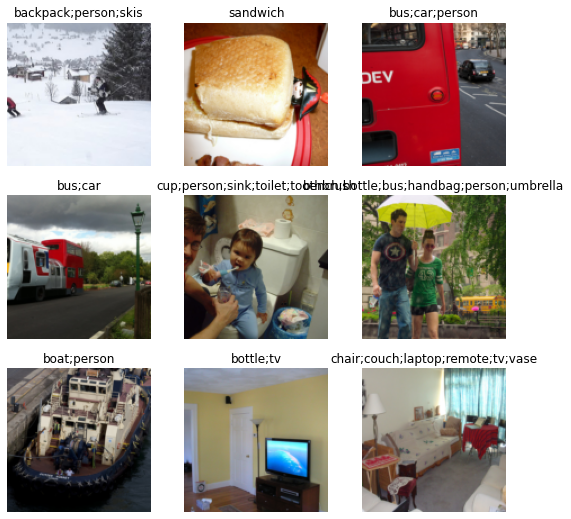

In [ ]:
dls.show_batch()

# Training

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(2, base_lr=3e-4, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.854059,0.688569,0.587656,01:56
1,0.138472,0.106075,0.969109,01:43
2,0.097445,0.084871,0.971952,01:44
3,0.088128,0.080070,0.973148,01:44


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.082083,0.075389,0.974305,01:45
1,0.081896,0.074181,0.974696,01:45


Can't argue with that accuracy!

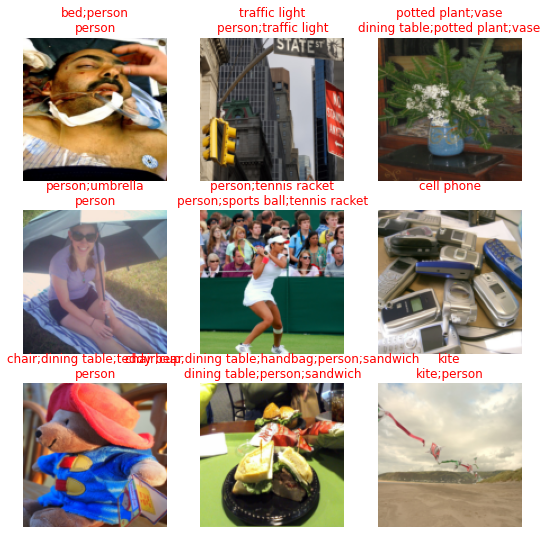

In [ ]:
learn.show_results()

Actually, you can argue with it... It seems to have learned to identify `person`, the category with by far the most instances. It's learned to identify some other labels, though, which is great!